In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn
import warnings
import joblib
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor


## Data Preperation

In [3]:
df = pd.read_csv('Datasets/SRQ_flights.csv')
df['actual_date'] = pd.to_datetime(df['actual_date'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14016 entries, 0 to 14015
Columns: 239 entries, Unnamed: 0 to interfacePriority.country
dtypes: datetime64[ns, UTC](1), float64(152), int64(9), object(77)
memory usage: 25.6+ MB


C:\Users\KamarioSinclair\AppData\Local\Temp\ipykernel_22508\1003189184.py:1: DtypeWarning: Columns (35,45,49,55,56,58,60,68,78,90,107,137,139,184,185,189,194,227) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Datasets/SRQ_flights.csv')


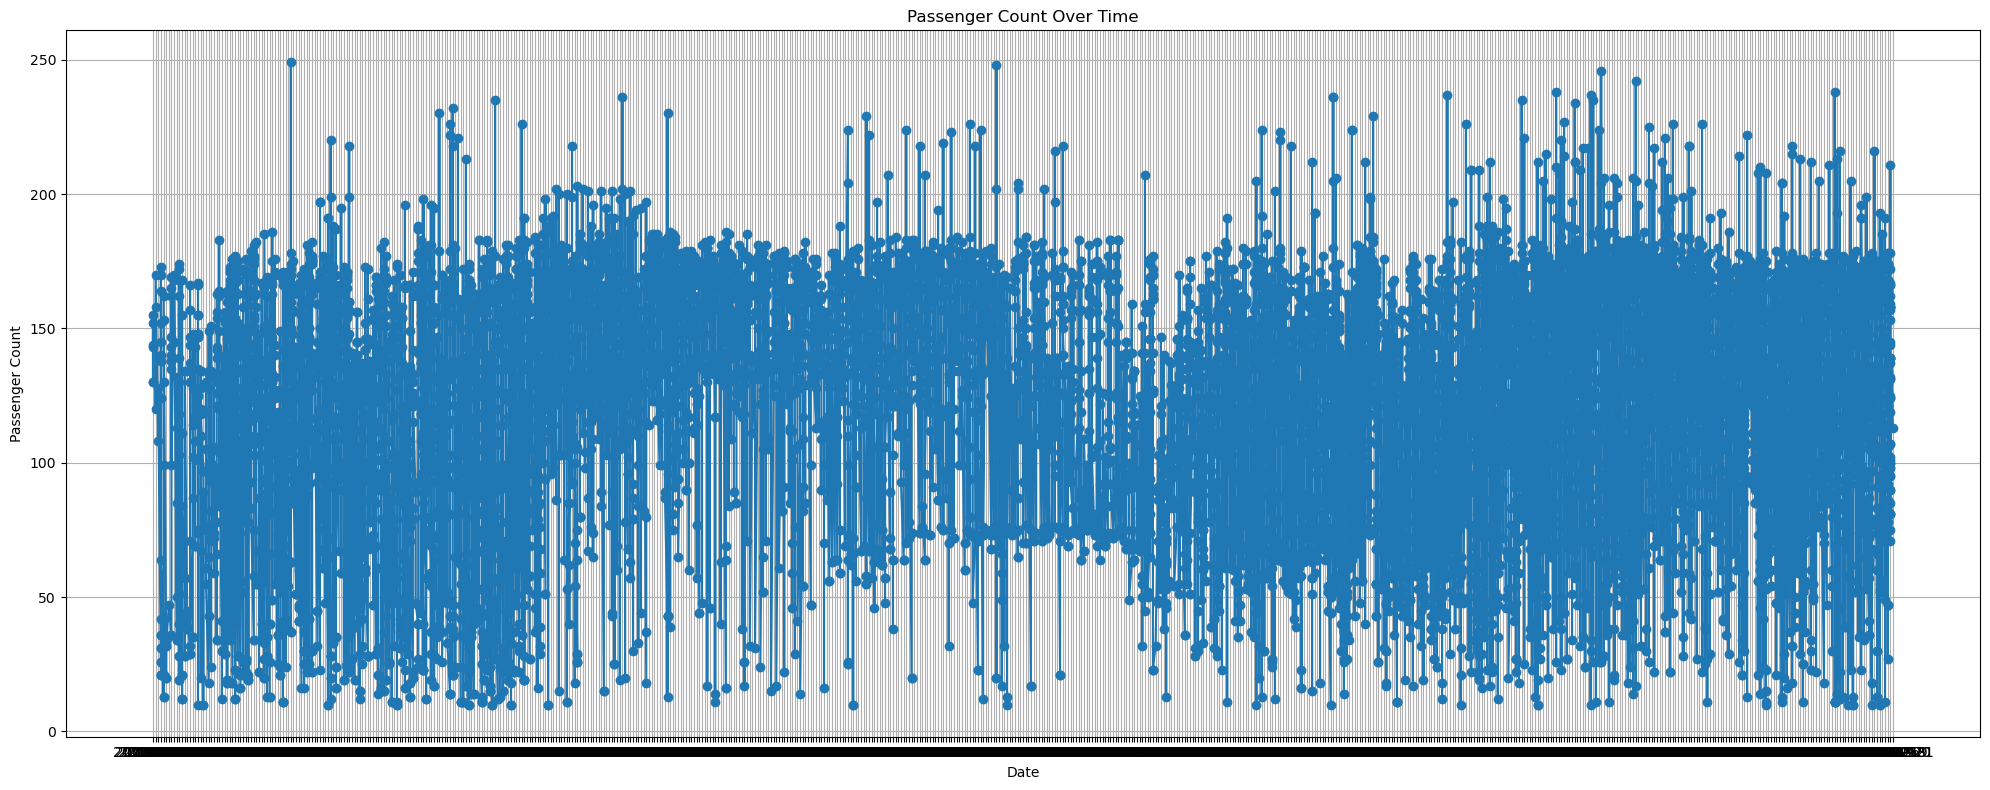

In [4]:
plt.figure(figsize=(20,8))
plt.plot(df['Date'], df['Boarded'], marker='o', linestyle='-')
plt.title('Passenger Count Over Time')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Extract time-based features
#df['Hour'] = df['Flight Time'].dt.hour
df['Day_of_Week'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['Date'].dt.month
df['Day_of_Month'] = df['Date'].dt.day

# Create time-based categories
#df['Time_Category'] = pd.cut(df['Hour'], 
                           #bins=[0, 6, 12, 18, 24], 
                           #labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Destination Airport', 'Airline']

for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

df

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
df['day_sin'] = np.sin(2*np.pi*df['Day_of_Month']/31)
df['day_cos'] = np.cos(2*np.pi*df['Day_of_Month']/31)

# Month (1–12) → convert to 0–11 by subtracting 1, then encode
df['month_sin'] = np.sin(2 * np.pi * (df['Month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['Month'] - 1) / 12)

# Day of Week → if 0=Monday…6=Sunday, just divide by 7
df['dow_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)

df.info()

In [6]:
#Extract time of day in seconds
df['seconds_in_day'] = (
    df['actual_date'].dt.hour * 3600 +
    df['actual_date'].dt.minute * 60 +
    df['actual_date'].dt.second
)

# Normalize to [0, 2π]
seconds_in_day_total = 24 * 60 * 60  # 86400
df['time_angle'] = 2 * np.pi * df['seconds_in_day'] / seconds_in_day_total

# Compute sin and cos
df['time_sin'] = np.sin(df['time_angle'])
df['time_cos'] = np.cos(df['time_angle'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14016 entries, 0 to 14015
Columns: 243 entries, Unnamed: 0 to time_cos
dtypes: datetime64[ns, UTC](1), float64(156), int64(9), object(77)
memory usage: 26.0+ MB


In [7]:
route_stats = df.groupby(['Airline','Destination Airport'])['Boarded'].agg([
    ('route_mean','mean'),
    ('route_median','median'),
    ('route_std','std'),
]).reset_index()
df = df.merge(route_stats, on=['Airline','Destination Airport'], how='left')
df

,Unnamed: 0,Date,Flight,Destination Airport,Airline,Boarded,Day_of_Week,Month,Day_of_Month,Destination Airport_encoded,...,interfacePriority.flight_stop_names,interfacePriority.flight_stop_codes,interfacePriority.country,seconds_in_day,time_angle,time_sin,time_cos,route_mean_y,route_median_y,route_std_y
0,0,2023-09-14,AA2679,DFW,AA,130,3,9,14,23,...,NaN,NaN,NaN,70920.0,5.157448,-0.902585,0.430511,94.507092,93.0,51.832487
1,0,2023-09-14,AA2679,DFW,AA,130,3,9,14,23,...,NaN,NaN,NaN,77520.0,5.637413,-0.601815,0.798636,94.507092,93.0,51.832487
2,1,2023-09-14,G41150,PIT,G4,155,3,9,14,60,...,NaN,NaN,NaN,300.0,0.021817,0.021815,0.999762,153.380392,163.0,28.041877
3,2,2023-09-14,G4183,ABE,G4,152,3,9,14,0,...,NaN,NaN,NaN,60540.0,4.402593,-0.952396,-0.304864,153.425150,159.0,21.267490
4,3,2023-09-14,G4218,AVL,G4,144,3,9,14,6,...,NaN,NaN,NaN,85380.0,6.209009,-0.074108,0.997250,127.860104,134.0,34.083019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14011,12555,2025-07-20,WN4409,IND,WN,71,6,7,20,40,...,NaN,NaN,NaN,75060.0,5.458517,-0.734323,0.678801,106.051282,111.0,36.059124
14012,12556,2025-07-20,WN4605,MDW,WN,125,6,7,20,49,...,NaN,NaN,NaN,58860.0,4.280420,-0.908143,-0.418660,119.988372,122.0,39.125079
14013,12557,2025-07-20,WN4606,STL,WN,75,6,7,20,71,...,NaN,NaN,NaN,51540.0,3.748095,-0.569997,-0.821647,122.328244,131.0,34.421917
14014,12558,2025-07-20,XP306,HVN,XP,132,6,7,20,36,...,NaN,NaN,NaN,85800.0,6.239552,-0.043619,0.999048,123.730205,129.0,33.011370


In [8]:
df

,Unnamed: 0,Date,Flight,Destination Airport,Airline,Boarded,Day_of_Week,Month,Day_of_Month,Destination Airport_encoded,...,interfacePriority.flight_stop_names,interfacePriority.flight_stop_codes,interfacePriority.country,seconds_in_day,time_angle,time_sin,time_cos,route_mean_y,route_median_y,route_std_y
0,0,2023-09-14,AA2679,DFW,AA,130,3,9,14,23,...,NaN,NaN,NaN,70920.0,5.157448,-0.902585,0.430511,94.507092,93.0,51.832487
1,0,2023-09-14,AA2679,DFW,AA,130,3,9,14,23,...,NaN,NaN,NaN,77520.0,5.637413,-0.601815,0.798636,94.507092,93.0,51.832487
2,1,2023-09-14,G41150,PIT,G4,155,3,9,14,60,...,NaN,NaN,NaN,300.0,0.021817,0.021815,0.999762,153.380392,163.0,28.041877
3,2,2023-09-14,G4183,ABE,G4,152,3,9,14,0,...,NaN,NaN,NaN,60540.0,4.402593,-0.952396,-0.304864,153.425150,159.0,21.267490
4,3,2023-09-14,G4218,AVL,G4,144,3,9,14,6,...,NaN,NaN,NaN,85380.0,6.209009,-0.074108,0.997250,127.860104,134.0,34.083019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14011,12555,2025-07-20,WN4409,IND,WN,71,6,7,20,40,...,NaN,NaN,NaN,75060.0,5.458517,-0.734323,0.678801,106.051282,111.0,36.059124
14012,12556,2025-07-20,WN4605,MDW,WN,125,6,7,20,49,...,NaN,NaN,NaN,58860.0,4.280420,-0.908143,-0.418660,119.988372,122.0,39.125079
14013,12557,2025-07-20,WN4606,STL,WN,75,6,7,20,71,...,NaN,NaN,NaN,51540.0,3.748095,-0.569997,-0.821647,122.328244,131.0,34.421917
14014,12558,2025-07-20,XP306,HVN,XP,132,6,7,20,36,...,NaN,NaN,NaN,85800.0,6.239552,-0.043619,0.999048,123.730205,129.0,33.011370


In [9]:
# Select features for modeling
feature_columns = [
    'Destination Airport_encoded', 'Airline_encoded',
    #'Day_of_Week', 'Month', 'Day_of_Month', 
    'day_sin',  'month_sin', 'dow_sin',
    'day_cos', 'month_cos', 'dow_cos', 
    'route_mean_y', 'route_median_y', 'route_std_y',
    'time_sin', 'time_cos', 'max_seats'
]

X = df[feature_columns]
y = df['Boarded']

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (14016, 14)
Target shape: (14016,)


In [10]:
#Need to drop time stamps for modeling but need the timestamps to present data
df_timestamps = df['Date']

split_factor = 0.8
split_index = int(len(df) * split_factor)

train_df = df[:split_index]
test_df = df[split_index:]

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=None
# )

# Extract X and y from train and test sets
X_train = train_df[feature_columns]
y_train = train_df['Boarded']

X_test = test_df[feature_columns]
y_test = test_df['Boarded']


print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training target range: {y_train.min()} to {y_train.max()}")
print(f"Testing target range: {y_test.min()} to {y_test.max()}")

Training set size: 11212
Testing set size: 2804
Training target range: 10 to 249
Testing target range: 10 to 238


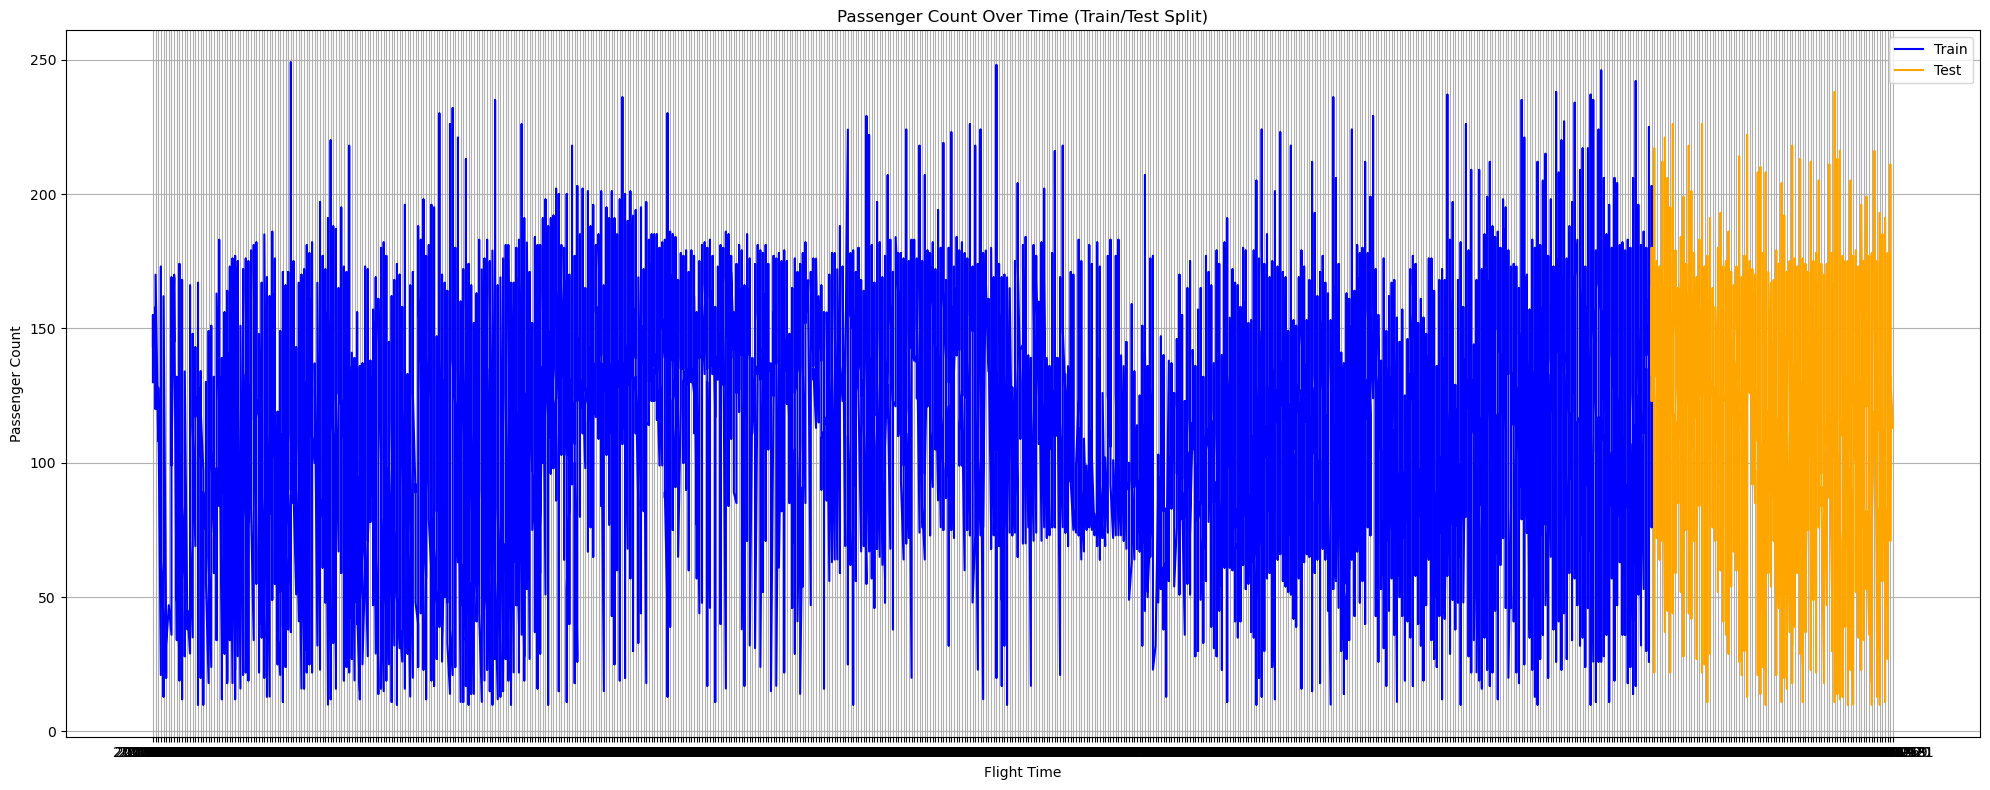

In [11]:
plt.figure(figsize=(20,8))

plt.plot(df_timestamps[:split_index], y_train, label='Train', color='blue')
plt.plot(df_timestamps[split_index:], y_test, label='Test', color='orange')

plt.title('Passenger Count Over Time (Train/Test Split)')
plt.xlabel('Flight Time')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## XGBoost

In [12]:
tscv= TimeSeriesSplit(3)

In [13]:
# arameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

# xgb_grid = GridSearchCV(xgb1,
#                         parameters,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

In [14]:
param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.1, 0.01, .03, .07], #so called `eta` value [.03, 0.05, .07]
              'max_depth': [4, 5, 6,],
              'min_child_weight': [4],
              'verbosity': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [600]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=tscv)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

In [15]:
# Training the XGBoost model

from xgboost import XGBRegressor

xgb_model = XGBRegressor(**best_params)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=4, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, nthread=4, ...)

In [16]:
# Evaluating the XGBoost model on the testing set square based loss function

predictions = xgb_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Model Performance on Test Set:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")
#print(f"Out-of-Bag Score: {best_rf.oob_score_:.4f}")

# Context for interpretation
print(f"\nFor context:")
print(f"Average passenger count: {y_test.mean():.1f}")
print(f"Typical prediction error: ±{rmse:.1f} passengers")

Model Performance on Test Set:
Mean Squared Error: 773.2092
Root Mean Squared Error: 27.8066
Mean Absolute Error: 20.5388
R-squared Score: 0.4735

For context:
Average passenger count: 126.0
Typical prediction error: ±27.8 passengers


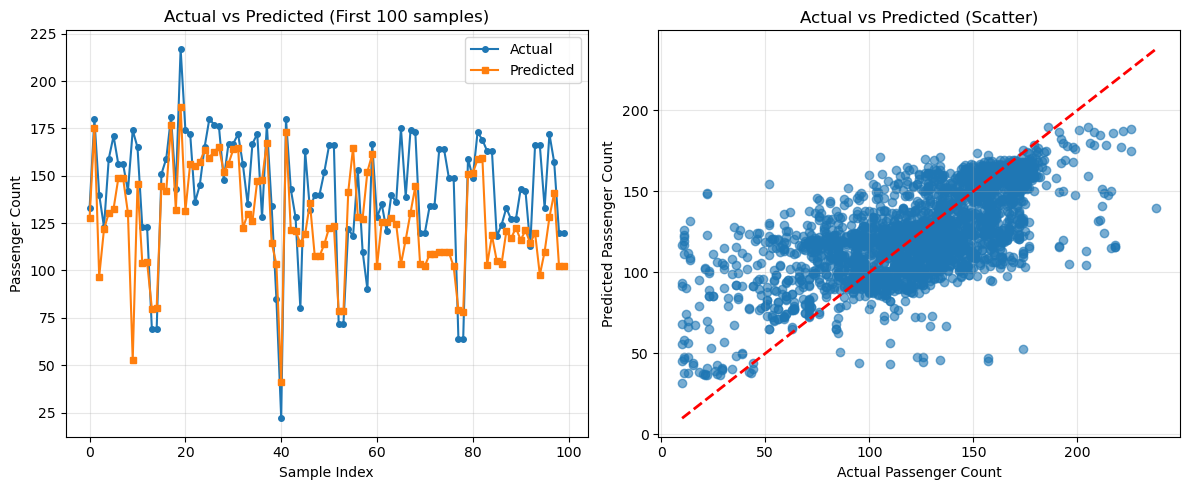

In [17]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))

# Line plot
plt.subplot(1, 2, 1)
plt.plot(y_test.values[:100], label='Actual', marker='o', markersize=4)
plt.plot(predictions[:100], label='Predicted', marker='s', markersize=4)
plt.title('Actual vs Predicted (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.title('Actual vs Predicted (Scatter)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Feature Importance:
                        feature  importance
9                route_median_y    0.368599
8                  route_mean_y    0.236002
1               Airline_encoded    0.101825
3                     month_sin    0.051897
13                    max_seats    0.040798
7                       dow_cos    0.036494
6                     month_cos    0.034956
10                  route_std_y    0.025682
11                     time_sin    0.023035
2                       day_sin    0.019688
4                       dow_sin    0.016721
12                     time_cos    0.015734
5                       day_cos    0.014507
0   Destination Airport_encoded    0.014062


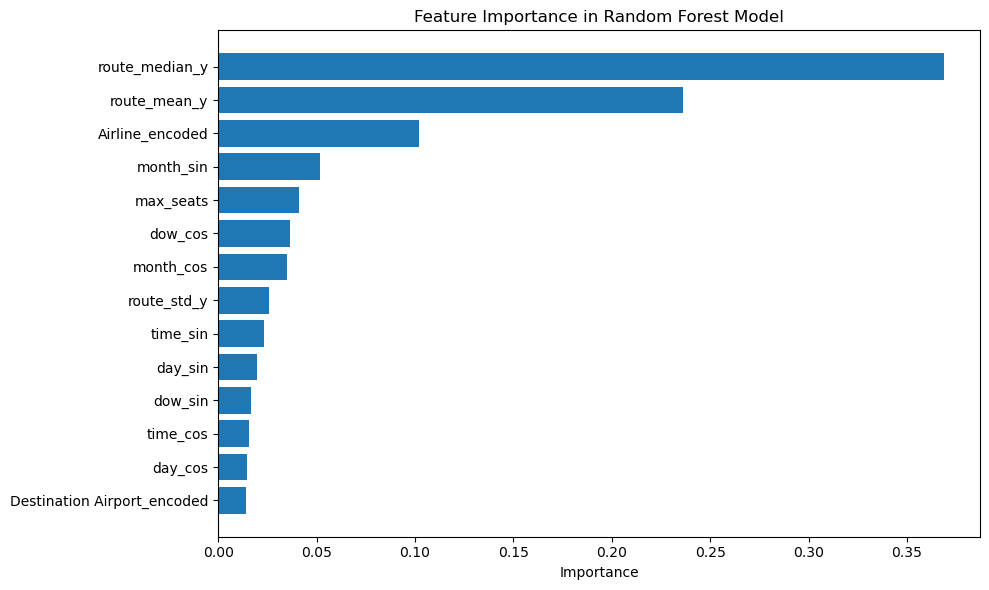

In [18]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [19]:
sad = np.sum(np.abs(predictions - y_test))
print("SAD:", sad)

SAD: 57590.688608169556
